[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Train YOLO11 Object Detection on a Custom Dataset

---

[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/ultralytics/ultralytics)

YOLO11 builds on the advancements introduced in YOLOv9 and YOLOv10 earlier this year, incorporating improved architectural designs, enhanced feature extraction techniques, and optimized training methods.

YOLO11m achieves a higher mean mAP score on the COCO dataset while using 22% fewer parameters than YOLOv8m, making it computationally lighter without sacrificing performance.

YOLOv11 is available in 5 different sizes, ranging from `2.6M` to `56.9M` parameters, and capable of achieving from `39.5` to `54.7` mAP on the COCO dataset.

## Setup

### Configure API keys

To fine-tune YOLO11, you need to provide your Roboflow API key. Follow these steps:

- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑). Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

### Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
# 버전이 안 맞아서 에러가 날 경우
!pip install --upgrade ultralytics

In [2]:
# 내 컴퓨터의 nvidia 그래픽 드라이버 정보 확인
!nvidia-smi

Tue Jul 29 14:21:27 2025       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 528.49       Driver Version: 528.49       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| 28%   42C    P8    17W / 125W |    875MiB /  6144MiB |      3%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [3]:
import os
# 현재 작업 디렉토리 HOME으로 지정
HOME = os.getcwd()
print(HOME)

c:\Users\SBA\github\yolo11


## Install YOLO11 via Ultralytics

YOLO 모델을 다루는 ultralytics,  
시각화 및 유틸리티를 위한 supervision,  
데이터셋 관리 및 플랫폼 연동을 위한 roboflow

In [4]:
%pip install "ultralytics<=8.3.40" supervision roboflow
# prevent ultralytics from tracking your activity

# Jupyter 환경에서 ultralytics 라이브러리가 사용자의 활동 데이터를 원격 서버와 동기화하지 않도록 설정
!yolo settings sync=False

import ultralytics
ultralytics.checks()

Ultralytics 8.3.40  Python-3.11.13 torch-2.7.1+cpu CPU (12th Gen Intel Core(TM) i7-12700)
Setup complete  (20 CPUs, 15.8 GB RAM, 127.1/456.7 GB disk)


## Inference with model pre-trained on COCO dataset

### CLI

**NOTE:** CLI requires no customization or Python code. You can simply run all tasks from the terminal with the yolo command.

In [5]:
# task=detect: 수행할 작업의 종류를 지정(객체를 탐지)
# conf=0.25: 신뢰도 점수가 25% (0.25) 이상인 탐지 결과만 유효한 것으로 간주하겠다는 뜻
!yolo task=detect mode=predict model=yolo11n.pt conf=0.25 source='https://media.roboflow.com/notebooks/examples/dog.jpeg' save=True

Ultralytics 8.3.40 🚀 Python-3.11.13 torch-2.7.1+cpu CPU (12th Gen Intel Core(TM) i7-12700)
YOLO11n summary (fused): 238 layers, 2,616,248 parameters, 0 gradients, 6.5 GFLOPs

image 1/1 c:\Users\SBA\github\yolo11\dog.jpeg: 640x384 2 persons, 1 car, 1 dog, 1 handbag, 55.6ms
Speed: 6.5ms preprocess, 55.6ms inference, 11.1ms postprocess per image at shape (1, 3, 640, 384)
Results saved to runs\detect\predict
💡 Learn more at https://docs.ultralytics.com/modes/predict



  0%|          | 0.00/5.35M [00:00<?, ?B/s]
100%|██████████| 5.35M/5.35M [00:00<00:00, 117MB/s]

  0%|          | 0.00/104k [00:00<?, ?B/s]
100%|██████████| 104k/104k [00:00<00:00, 16.1MB/s]


**NOTE:** Result annotated image got saved in `{HOME}/runs/detect/predict/`. Let's display it.

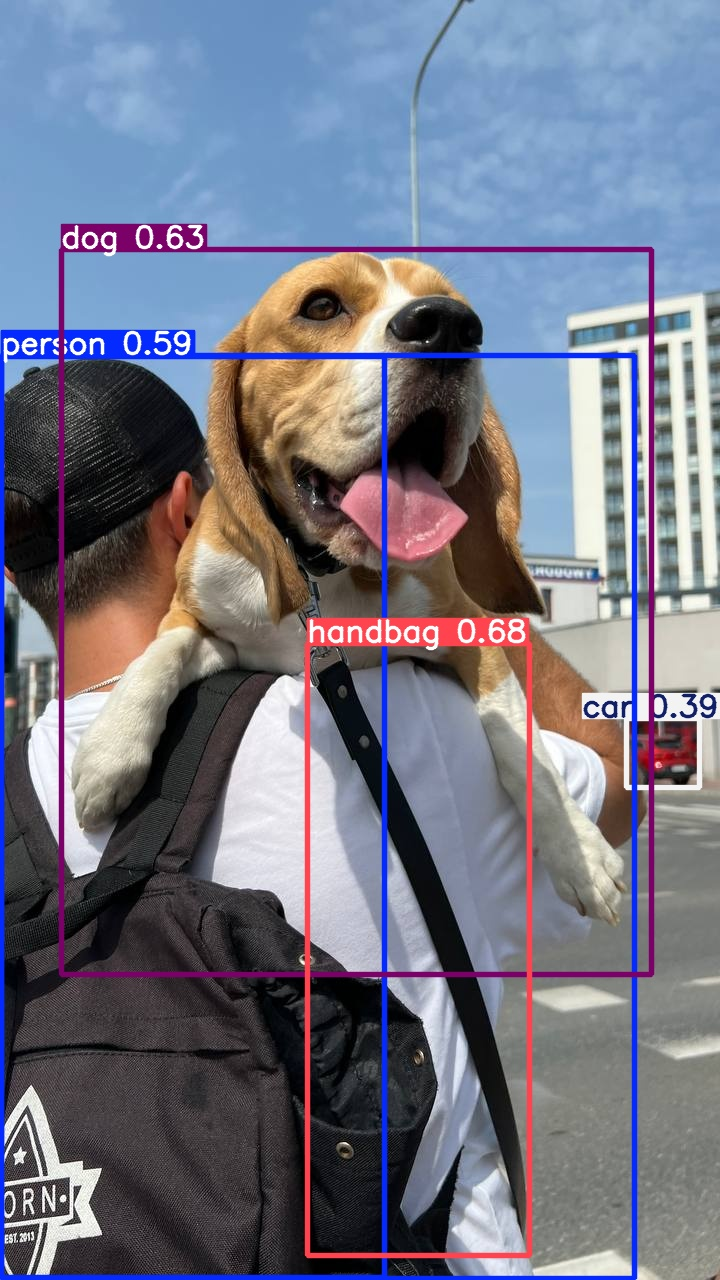

In [10]:
from IPython.display import Image as IPyImage

IPyImage(filename=r'C:\Users\SBA\github\yolo11\runs\detect\predict\dog.jpg', width=600)

### SDK

**NOTE:** YOLO's Python interface allows for seamless integration into your Python projects, making it easy to load, run, and process the model's output.

In [11]:
from ultralytics import YOLO
from PIL import Image
import requests

model = YOLO('yolo11n.pt')
image = Image.open(requests.get('https://media.roboflow.com/notebooks/examples/dog.jpeg', stream=True).raw)
result = model.predict(image, conf=0.25)[0]


0: 640x384 2 persons, 1 car, 1 dog, 1 handbag, 57.1ms
Speed: 1.9ms preprocess, 57.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


**NOTE:** The obtained `result` object stores information about the location, classes, and confidence levels of the detected objects.

In [12]:
# 탐지된 각 객체의 바운딩 박스(bounding box) 좌표
result.boxes.xyxy

tensor([[3.0705e+02, 6.4341e+02, 5.2919e+02, 1.2558e+03],
        [6.1400e+01, 2.4994e+02, 6.5165e+02, 9.7412e+02],
        [1.7803e+00, 3.5551e+02, 6.3404e+02, 1.2788e+03],
        [1.1933e+00, 3.5620e+02, 3.8455e+02, 1.2776e+03],
        [6.2615e+02, 7.1818e+02, 6.9975e+02, 7.8754e+02]])

In [13]:
# 탐지된 각 객체에 대한 신뢰도(Confidence) 점수
result.boxes.conf

tensor([0.6832, 0.6284, 0.5941, 0.3923, 0.3875])

In [14]:
# 탐지된 각 객체의 클래스(Class) ID
result.boxes.cls

tensor([26., 16.,  0.,  0.,  2.])

**NOTE:** YOLO11 can be easily integrated with `supervision` using the familiar `from_ultralytics` connector.

In [16]:
# supervision 라이브러리를 sv라는 짧은 별칭으로 임포트
import supervision as sv

# ultralytics YOLO 모델의 예측 결과(result)를 supervision 라이브러리가 이해하고 쉽게 다룰 수 있는 Detections 객체로 변환
detections = sv.Detections.from_ultralytics(result)

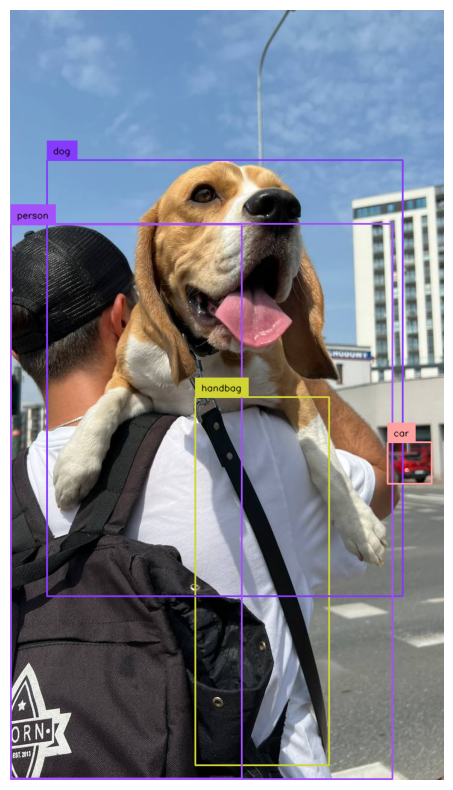

In [17]:
# 박스 생성
box_annotator = sv.BoxAnnotator()
# 레이블 생성
label_annotator = sv.LabelAnnotator(text_color=sv.Color.BLACK)

annotated_image = image.copy()
# 실제 이미지에다가 박스를 그리고
annotated_image = box_annotator.annotate(annotated_image, detections=detections)
# 실제 이미지에다가 레이블을 그리고
annotated_image = label_annotator.annotate(annotated_image, detections=detections)

# 이미지 출력
sv.plot_image(annotated_image, size=(10, 10))

## Fine-tune YOLO11 on custom dataset

**NOTE:** When training YOLOv11, make sure your data is located in `datasets`. If you'd like to change the default location of the data you want to use for fine-tuning, you can do so through Ultralytics' `settings.json`. In this tutorial, we will use one of the [datasets](https://universe.roboflow.com/liangdianzhong/-qvdww) available on [Roboflow Universe](https://universe.roboflow.com/). When downloading, make sure to select the `yolov11` export format.

In [ ]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

from google.colab import userdata
from roboflow import Roboflow

!curl -L "https://public.roboflow.com/ds/VoJLgFvCEB?key=tgCALUZmNn" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

# ROBOFLOW_API_KEY = userdata.get('ROBOFLOW_API_KEY')
# rf = Roboflow(api_key=ROBOFLOW_API_KEY)

# workspace = rf.workspace("liangdianzhong")
# project = workspace.project("-qvdww")
# version = project.version(3)
# dataset = version.download("yolov11")

/content/datasets
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   904  100   904    0     0   1891      0 --:--:-- --:--:-- --:--:--  1895
100 45.9M  100 45.9M    0     0  9371k      0  0:00:05  0:00:05 --:--:-- 11.0M
Archive:  roboflow.zip
  inflating: README.dataset.txt      
  inflating: README.roboflow.txt     
  inflating: data.yaml               
   creating: test/
   creating: test/images/
 extracting: test/images/img-105_jpg.rf.3fe9dff3d1631e79ecb480ff403bcb86.jpg  
 extracting: test/images/img-107_jpg.rf.2e40485785f6e5e2efec404301b235c2.jpg  
 extracting: test/images/img-146_jpg.rf.61be25b3053a51f622a244980545df2b.jpg  
 extracting: test/images/img-161_jpg.rf.211541e7178a4a93ec0680f26b905427.jpg  
 extracting: test/images/img-168_jpg.rf.af3590e07b06b43e91fa53990ff94af3.jpg  
 extracting: test/images/img-179_jpg.rf.8632eb0d9b75fefe144829e67b75015a.jpg  
 extractin

## Custom Training

In [ ]:
%cd {HOME}

!yolo task=detect mode=train model=yolo11s.pt data=/content/datasets/data.yaml epochs=10 imgsz=640 plots=True

/content
100% 18.4M/18.4M [00:00<00:00, 382MB/s]
New https://pypi.org/project/ultralytics/8.3.170 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.40 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11s.pt, data=/content/datasets/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retin

**NOTE:** The results of the completed training are saved in `{HOME}/runs/detect/train/`. Let's examine them.

In [ ]:
!ls {HOME}/runs/detect/train/

args.yaml					    results.png
confusion_matrix_normalized.png			    train_batch0.jpg
confusion_matrix.png				    train_batch1.jpg
events.out.tfevents.1753762500.ffba32f4dade.7098.0  train_batch2.jpg
F1_curve.png					    val_batch0_labels.jpg
labels_correlogram.jpg				    val_batch0_pred.jpg
labels.jpg					    val_batch1_labels.jpg
P_curve.png					    val_batch1_pred.jpg
PR_curve.png					    val_batch2_labels.jpg
R_curve.png					    val_batch2_pred.jpg
results.csv					    weights


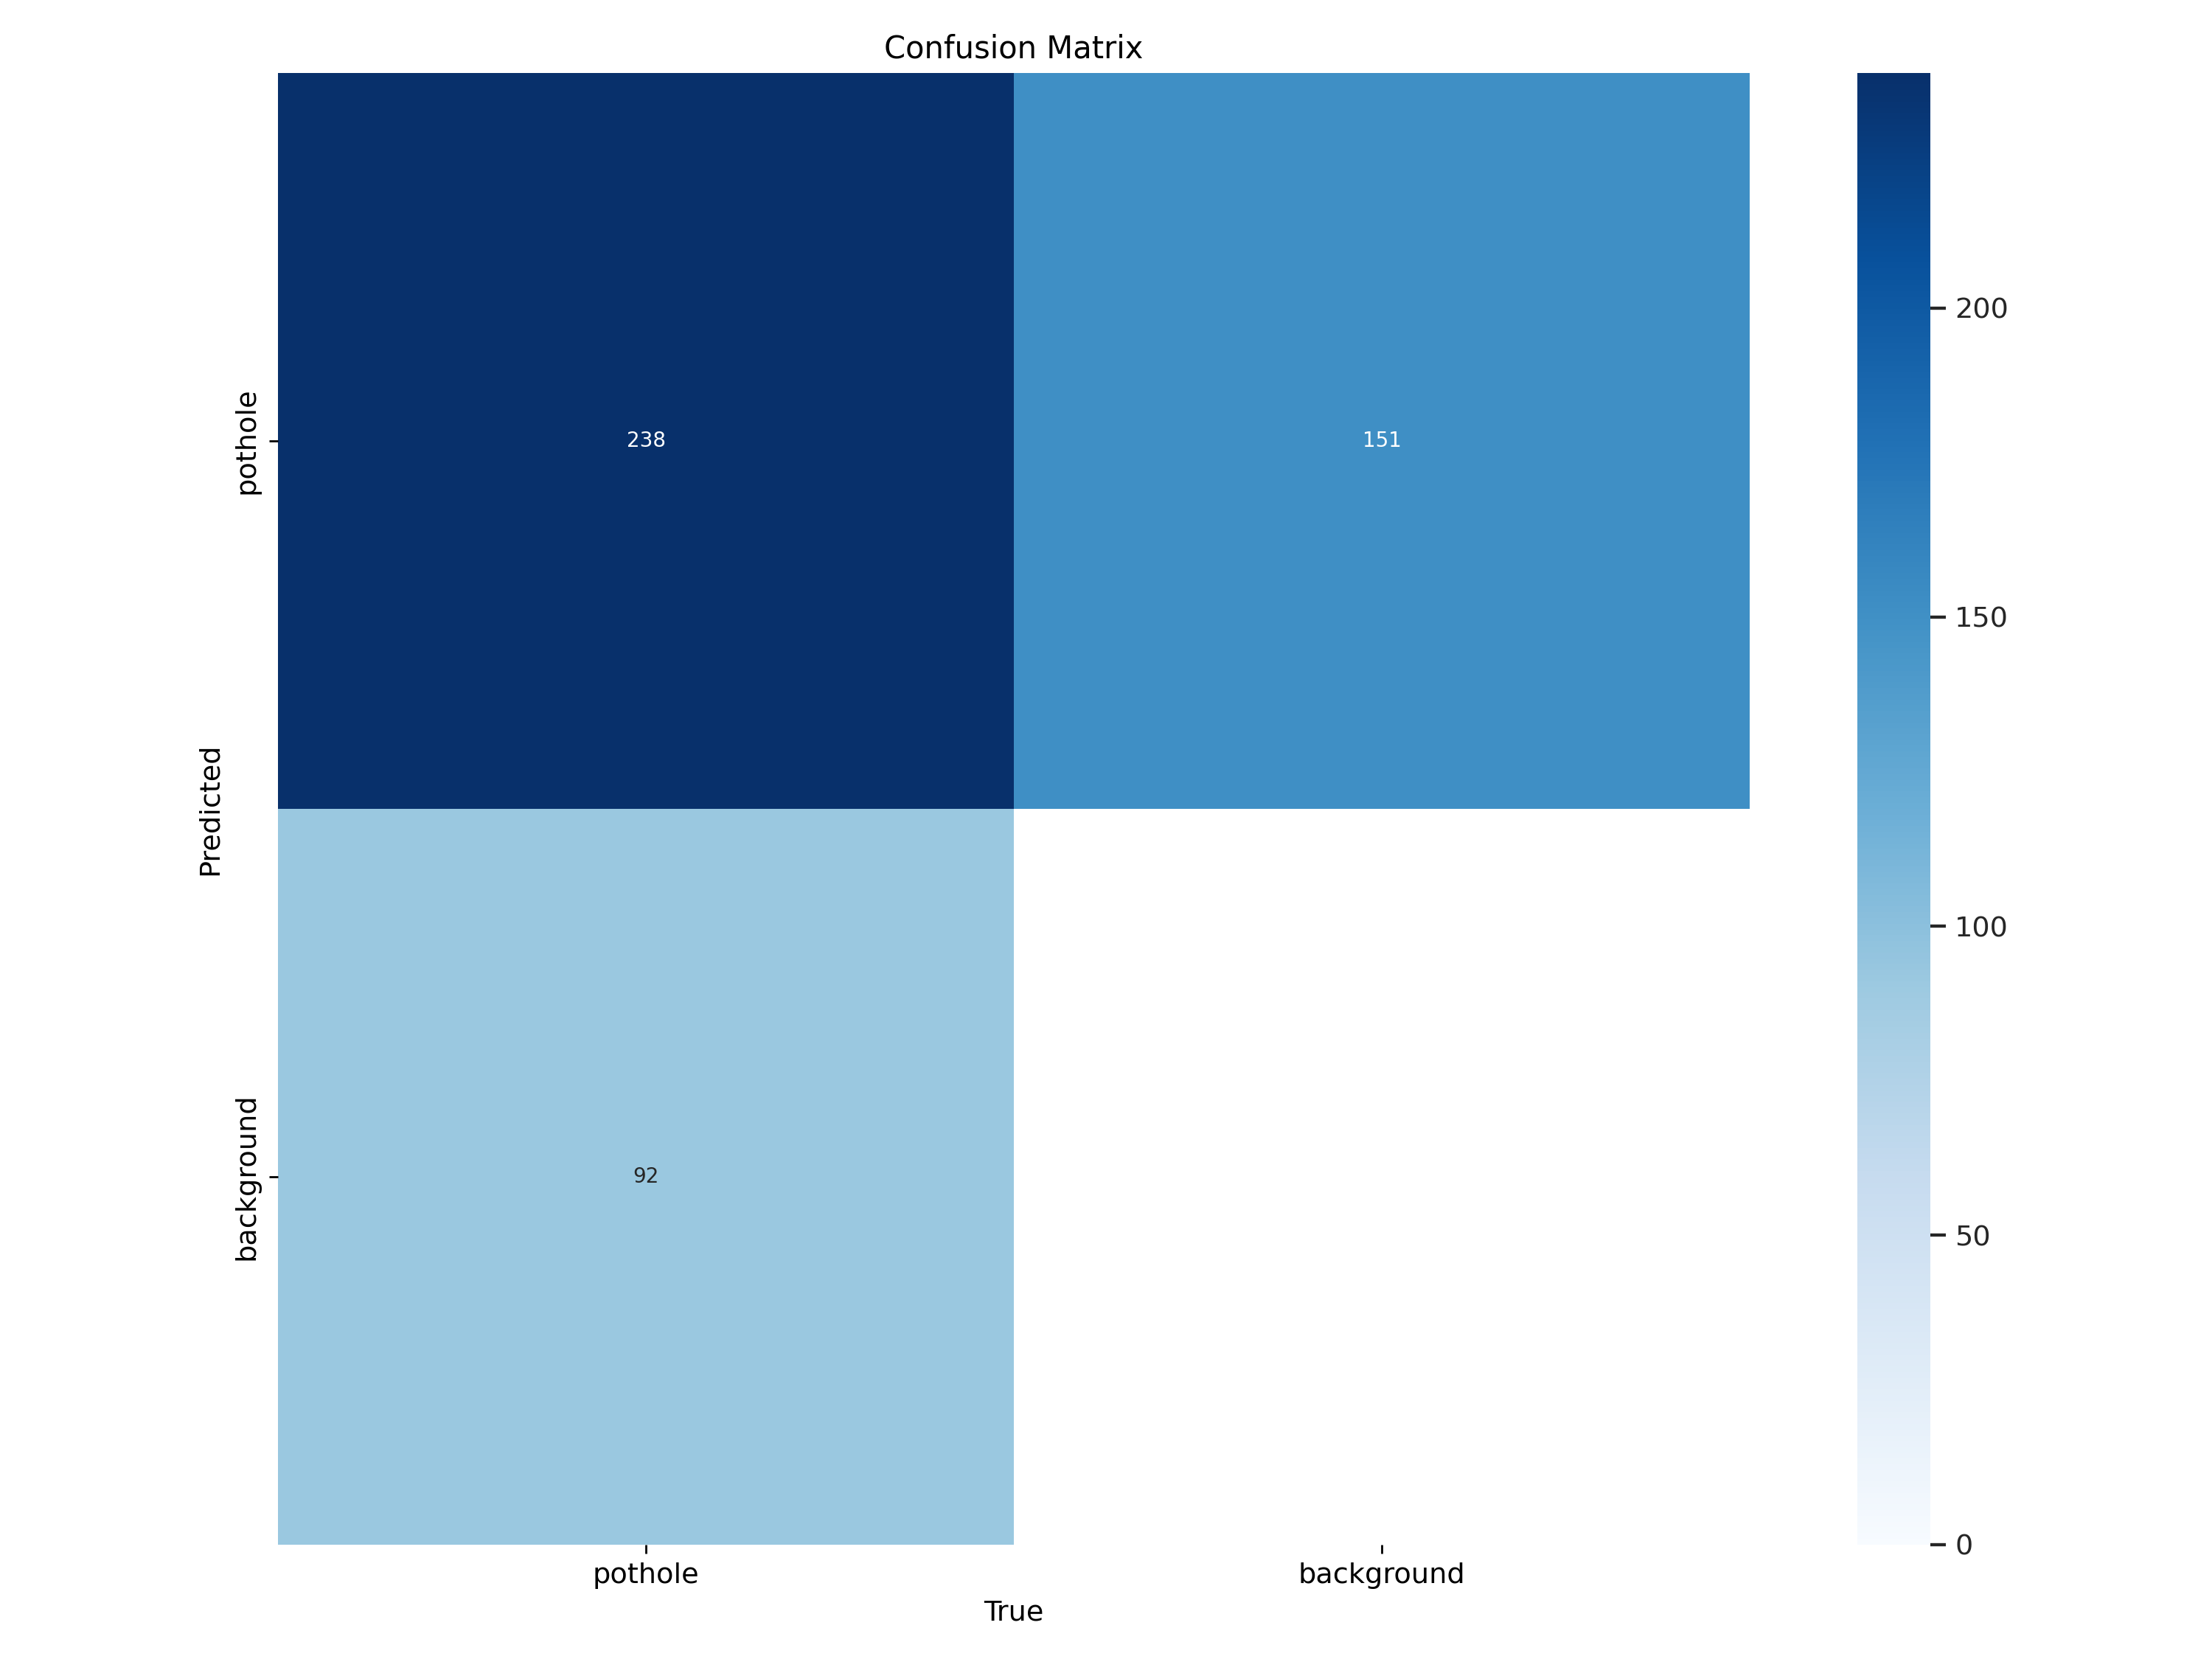

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=600)

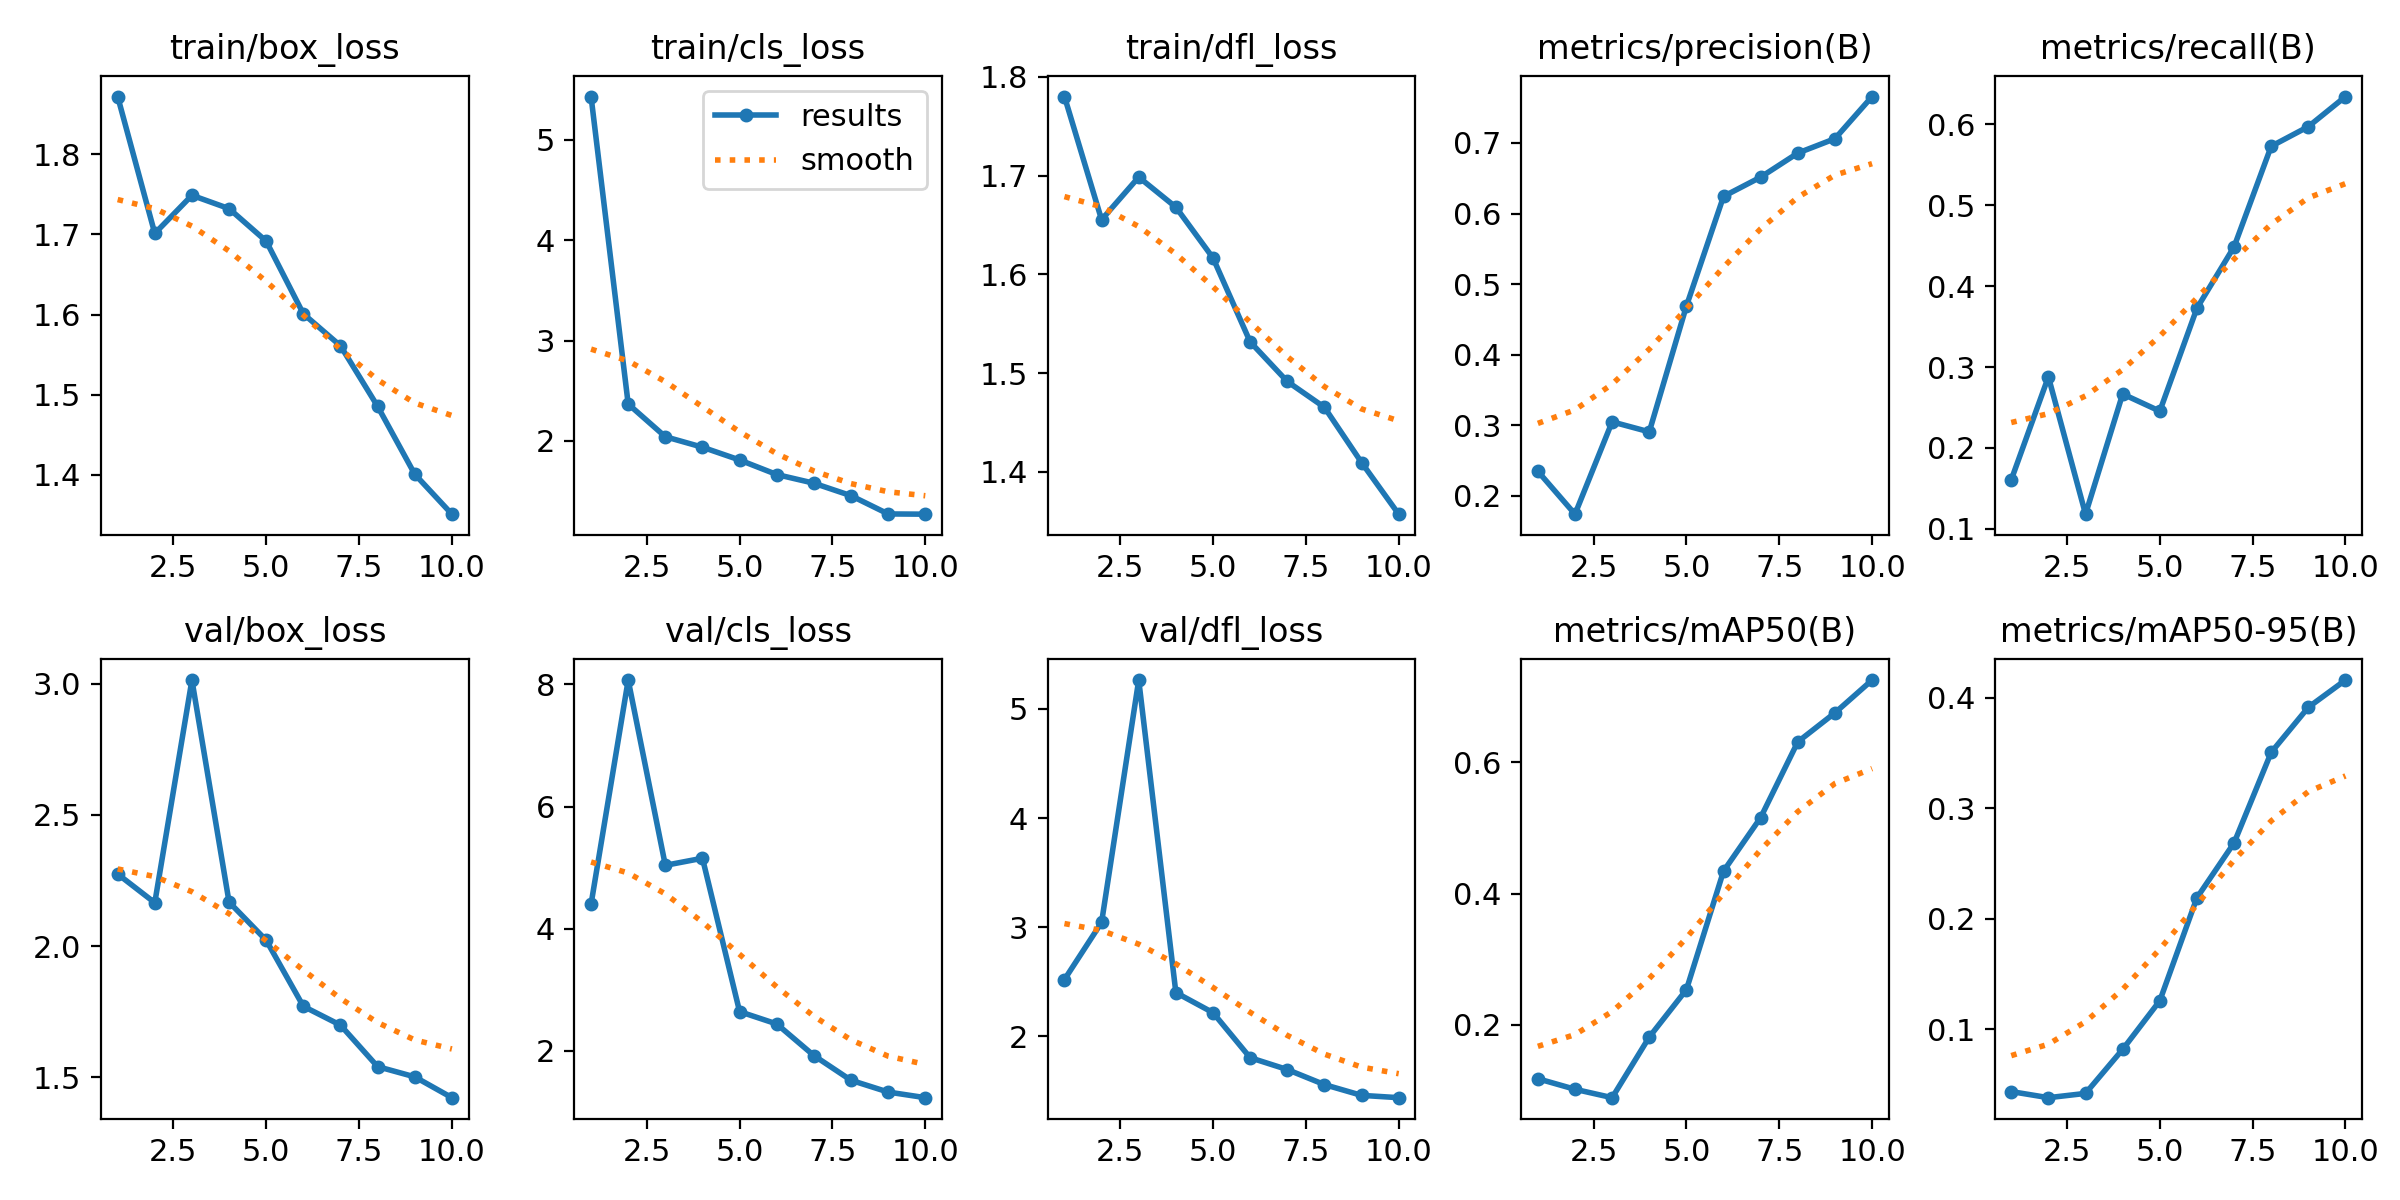

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/results.png', width=600)

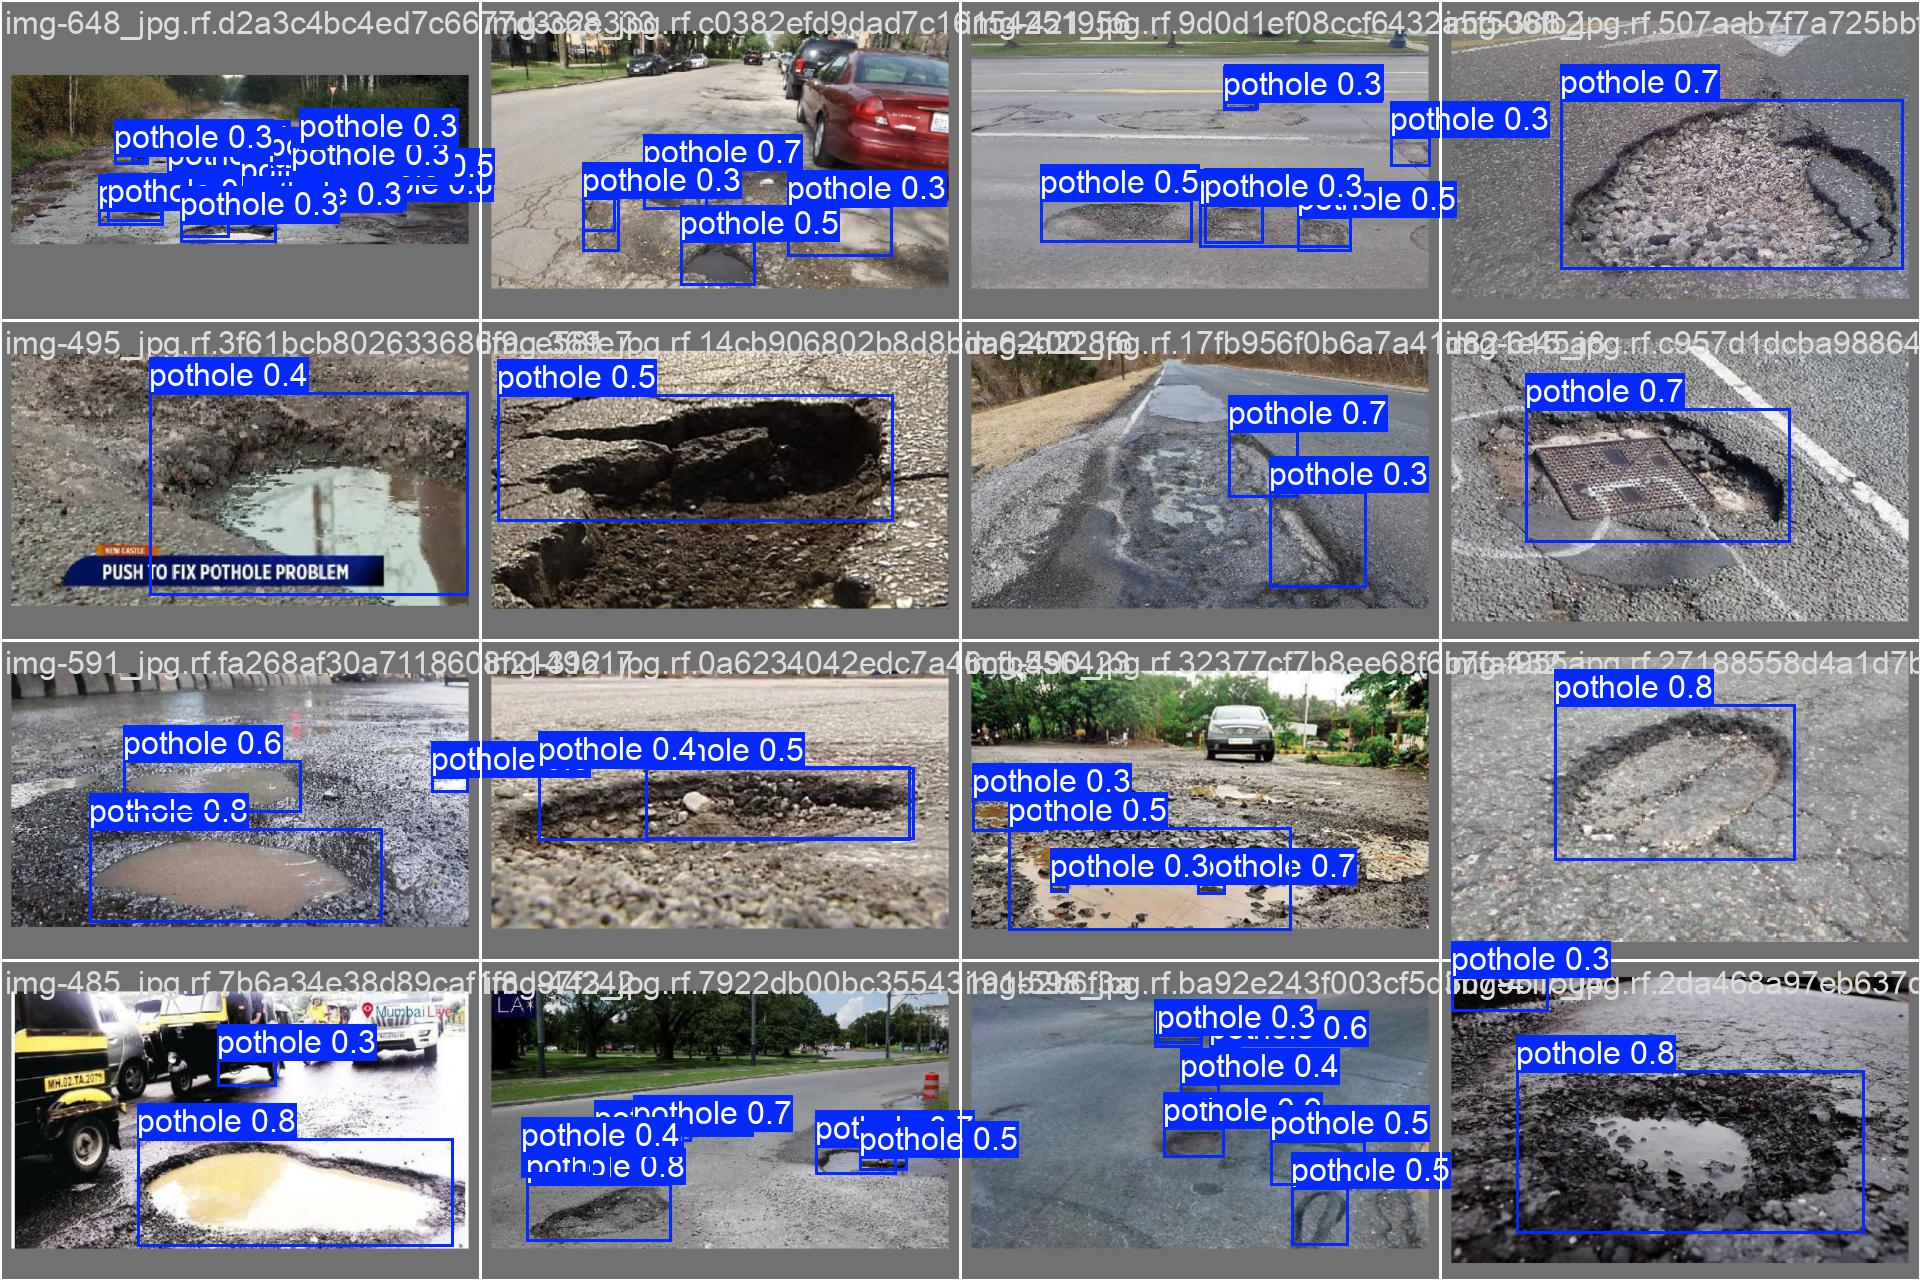

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/val_batch0_pred.jpg', width=600)

## Validate fine-tuned model

In [ ]:
!yolo task=detect mode=val model=/content/runs/detect/train/weights/best.pt data=/content/datasets/data.yaml

Ultralytics 8.3.40 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 238 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs
val: Scanning /content/datasets/valid/labels.cache... 133 images, 0 backgrounds, 0 corrupt: 100% 133/133 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 9/9 [00:03<00:00,  2.77it/s]
                   all        133        330      0.761      0.624      0.723      0.414
Speed: 0.9ms preprocess, 13.5ms inference, 0.0ms loss, 3.2ms postprocess per image
Results saved to runs/detect/val2
💡 Learn more at https://docs.ultralytics.com/modes/val


## Inference with custom model

In [ ]:
!yolo task=detect mode=predict model=/content/runs/detect/train/weights/best.pt conf=0.25 source=/content/datasets/test/images save=True

Ultralytics 8.3.40 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 238 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs

image 1/67 /content/datasets/test/images/img-105_jpg.rf.3fe9dff3d1631e79ecb480ff403bcb86.jpg: 640x640 2 potholes, 15.2ms
image 2/67 /content/datasets/test/images/img-107_jpg.rf.2e40485785f6e5e2efec404301b235c2.jpg: 640x640 3 potholes, 15.3ms
image 3/67 /content/datasets/test/images/img-146_jpg.rf.61be25b3053a51f622a244980545df2b.jpg: 640x640 1 pothole, 59.8ms
image 4/67 /content/datasets/test/images/img-161_jpg.rf.211541e7178a4a93ec0680f26b905427.jpg: 640x640 2 potholes, 46.3ms
image 5/67 /content/datasets/test/images/img-168_jpg.rf.af3590e07b06b43e91fa53990ff94af3.jpg: 640x640 3 potholes, 29.0ms
image 6/67 /content/datasets/test/images/img-179_jpg.rf.8632eb0d9b75fefe144829e67b75015a.jpg: 640x640 7 potholes, 15.3ms
image 7/67 /content/datasets/test/images/img-195_jpg.rf.f77a8f4d432a9a89235168ff8e09a650.jpg: 640x640 2 poth

**NOTE:** Let's take a look at few results.

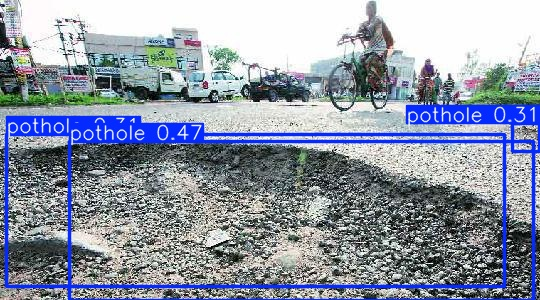

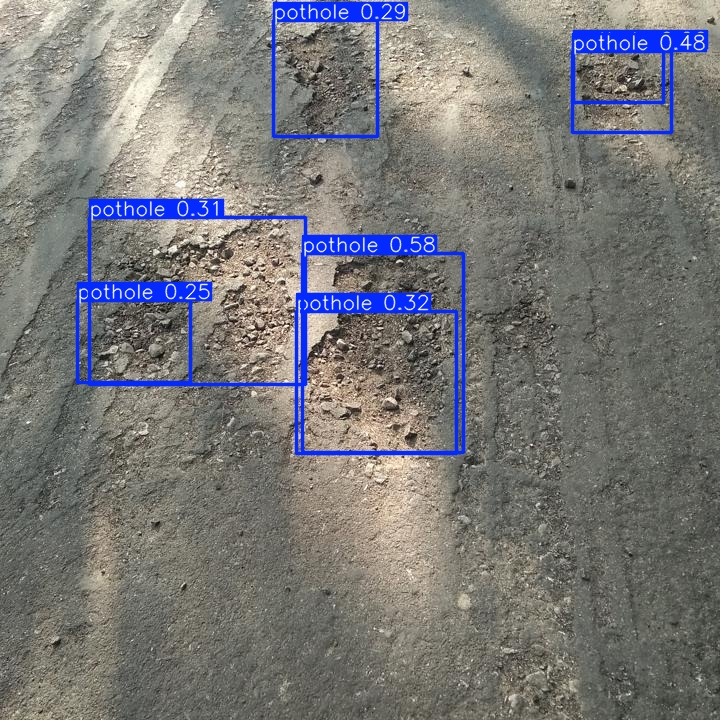

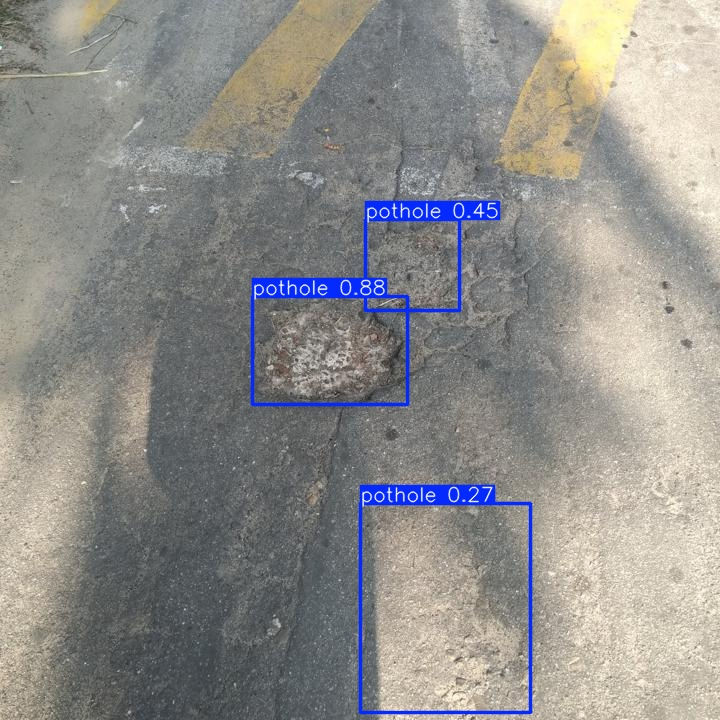

In [ ]:
import glob
import os
from IPython.display import Image as IPyImage, display

latest_folder = max(glob.glob(f'{HOME}/runs/detect/predict*/'), key=os.path.getmtime)
for img in glob.glob(f'{latest_folder}/*.jpg')[:3]:
    display(IPyImage(filename=img, width=600))
    print("\n")

# 여기서 부터는 배포임

## Deploy model on Roboflow

Once you have finished training your YOLOv11 model, you’ll have a set of trained weights ready for use. These weights will be in the `/runs/detect/train/weights/best.pt` folder of your project. You can upload your model weights to Roboflow Deploy to use your trained weights on our infinitely scalable infrastructure.

The `.deploy()` function in the [Roboflow pip package](https://docs.roboflow.com/python) now supports uploading YOLOv11 weights.

In [ ]:
project.version(dataset.version).deploy(model_type="yolov11", model_path=f"{HOME}/runs/detect/train/")

NameError: name 'project' is not defined

In [ ]:
!pip install inference

In [ ]:
import os, random, cv2
import supervision as sv
import IPython
import inference

model_id = project.id.split("/")[1] + "/" + dataset.version
model = inference.get_model(model_id, userdata.get('ROBOFLOW_API_KEY'))

# Location of test set images
test_set_loc = dataset.location + "/test/images/"
test_images = os.listdir(test_set_loc)

# Run inference on 4 random test images, or fewer if fewer images are available
for img_name in random.sample(test_images, min(4, len(test_images))):
    print("Running inference on " + img_name)

    # Load image
    image = cv2.imread(os.path.join(test_set_loc, img_name))

    # Perform inference
    results = model.infer(image, confidence=0.4, overlap=30)[0]
    detections = sv.Detections.from_inference(results)

    # Annotate boxes and labels
    box_annotator = sv.BoxAnnotator()
    label_annotator = sv.LabelAnnotator()
    annotated_image = box_annotator.annotate(scene=image, detections=detections)
    annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

    # Display annotated image
    _, ret = cv2.imencode('.jpg', annotated_image)
    i = IPython.display.Image(data=ret)
    IPython.display.display(i)


## 🏆 Congratulations

### Learning Resources

Roboflow has produced many resources that you may find interesting as you advance your knowledge of computer vision:

- [Roboflow Notebooks](https://github.com/roboflow/notebooks): A repository of over 20 notebooks that walk through how to train custom models with a range of model types, from YOLOv7 to SegFormer.
- [Roboflow YouTube](https://www.youtube.com/c/Roboflow): Our library of videos featuring deep dives into the latest in computer vision, detailed tutorials that accompany our notebooks, and more.
- [Roboflow Discuss](https://discuss.roboflow.com/): Have a question about how to do something on Roboflow? Ask your question on our discussion forum.
- [Roboflow Models](https://roboflow.com): Learn about state-of-the-art models and their performance. Find links and tutorials to guide your learning.

### Convert data formats

Roboflow provides free utilities to convert data between dozens of popular computer vision formats. Check out [Roboflow Formats](https://roboflow.com/formats) to find tutorials on how to convert data between formats in a few clicks.

### Connect computer vision to your project logic

[Roboflow Templates](https://roboflow.com/templates) is a public gallery of code snippets that you can use to connect computer vision to your project logic. Code snippets range from sending emails after inference to measuring object distance between detections.